Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# from Desktop.lime import lime
print('Notebook run using keras:', keras.__version__)

C:\Users\micha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Notebook run using keras: 2.2.0


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)


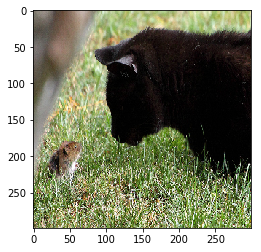

In [4]:
images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

(class, description, probability)

## Explanation
Now let's get an explanation

In [5]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [6]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [7]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

Wall time: 19min 37s


Follows same steps as LimeTextExp -- i.e. get neighborhood, train model to be like og model  
Perturb - on/off superpixels  

Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class ( Black Bear)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [8]:
from skimage.segmentation import mark_boundaries

Image Segmentation - process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics

[295, 224, 223, 106, 104]


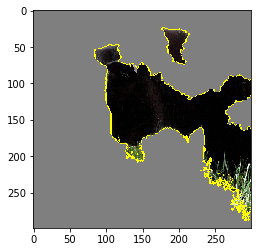

In [9]:
temp, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

print(explanation.top_labels)

Or with the rest of the image present:

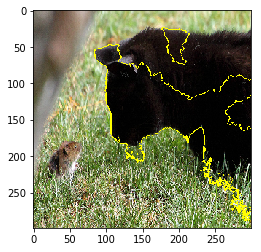

In [10]:
temp, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

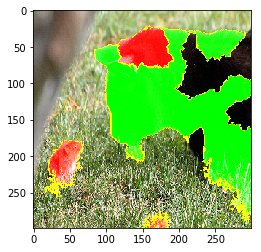

In [11]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

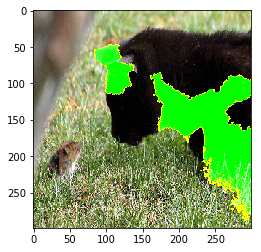

In [12]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# Testing Section!!

jupyter nbconvert --to script [YOUR_NOTEBOOK].ipynb

In [13]:
import types
from lime.utils.generic_utils import has_arg
from skimage.segmentation import felzenszwalb, slic, quickshift

class BaseWrapper(object):
    """Base class for LIME Scikit-Image wrapper


    Args:
        target_fn: callable function or class instance
        target_params: dict, parameters to pass to the target_fn


    'target_params' takes parameters required to instanciate the
        desired Scikit-Image class/model
    """

    def __init__(self, target_fn=None, **target_params):
        self.target_fn = target_fn
        self.target_params = target_params

        self.target_fn = target_fn
        self.target_params = target_params

    def _check_params(self, parameters):
        """Checks for mistakes in 'parameters'

        Args :
            parameters: dict, parameters to be checked

        Raises :
            ValueError: if any parameter is not a valid argument for the target function
                or the target function is not defined
            TypeError: if argument parameters is not iterable
         """
        a_valid_fn = []
        if self.target_fn is None:
            if callable(self):
                a_valid_fn.append(self.__call__)
            else:
                raise TypeError('invalid argument: tested object is not callable,\
                 please provide a valid target_fn')
        elif isinstance(self.target_fn, types.FunctionType) \
                or isinstance(self.target_fn, types.MethodType):
            a_valid_fn.append(self.target_fn)
        else:
            a_valid_fn.append(self.target_fn.__call__)

        if not isinstance(parameters, str):
            for p in parameters:
                for fn in a_valid_fn:
                    if has_arg(fn, p):
                        pass
                    else:
                        raise ValueError('{} is not a valid parameter'.format(p))
        else:
            raise TypeError('invalid argument: list or dictionnary expected')

    def set_params(self, **params):
        """Sets the parameters of this estimator.
        Args:
            **params: Dictionary of parameter names mapped to their values.

        Raises :
            ValueError: if any parameter is not a valid argument
                for the target function
        """
        self._check_params(params)
        self.target_params = params

    def filter_params(self, fn, override=None):
        """Filters `target_params` and return those in `fn`'s arguments.
        Args:
            fn : arbitrary function
            override: dict, values to override target_params
        Returns:
            result : dict, dictionary containing variables
            in both target_params and fn's arguments.
        """
        override = override or {}
        result = {}
        for name, value in self.target_params.items():
            if has_arg(fn, name):
                result.update({name: value})
        result.update(override)
        return result


class SegmentationAlgorithm(BaseWrapper):
    """ Define the image segmentation function based on Scikit-Image
            implementation and a set of provided parameters

        Args:
            algo_type: string, segmentation algorithm among the following:
                'quickshift', 'slic', 'felzenszwalb'
            target_params: dict, algorithm parameters (valid model paramters
                as define in Scikit-Image documentation)
    """

    def __init__(self, algo_type, **target_params):
        self.algo_type = algo_type
        if (self.algo_type == 'quickshift'):
            BaseWrapper.__init__(self, quickshift, **target_params)
            kwargs = self.filter_params(quickshift)
            self.set_params(**kwargs)
        elif (self.algo_type == 'felzenszwalb'):
            BaseWrapper.__init__(self, felzenszwalb, **target_params)
            kwargs = self.filter_params(felzenszwalb)
            self.set_params(**kwargs)
        elif (self.algo_type == 'slic'):
            BaseWrapper.__init__(self, slic, **target_params)
            kwargs = self.filter_params(slic)
            self.set_params(**kwargs)

    def __call__(self, *args):
            return self.target_fn(args[0], **self.target_params)

In [14]:
# model_2 = explainer.base.model
# used_features = explanation.top_labels
# seg_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2, random_seed=explainer.random_seed)
# # Testing: Decreasing influence of superpixel
# # print(model_2.predict(seg_fn(images[0])[:, used_features].reshape(1, -1)))
# gamma = .2700

# prediction = 'American_black_bear'
# while gamma < 1 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask != 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] - gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     print("Originial Model:")
#     print(tup)
    
#     lo = np.where(alter_image < 1)
#     alter_image[lo] = -1
#     segments = seg_fn(alter_image)
#     print(segments)
# #     pred = model_2.predict(alter_image[:, used_features].reshape(1, -1))
#     pred = model_2.predict(np.ones((1, 55)).reshape(1, -1))
#     print("Linear Model:")
#     print(pred)
#     print(explanation.local_pred)
#     print(explanation.local_exp.keys())
#     gamma += .001

In [ ]:
# # Loop for cell below:
# # Testing: Decreasing / increasing influence of superpixel
# gamma = 1.00
# prediction = 'American_black_bear'
# while gamma <= 1.5 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask != 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] * gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     for x in decode_predictions(preds)[0]:
#         print(x)
#     gamma += .01
    
#     alt = alter_image.copy()
#     alt[np.where(alt > 1)] = 1
#     alt[np.where(alt < -1)] = -1
    
#     ex = lime_image.LimeImageExplainer()
#     expl = ex.explain_instance(alt, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)
#     print(expl_1.top_labels)
#     temp, mask = expl_1.get_image_and_mask(expl.top_labels, positive_only=False, num_features=10, hide_rest=False)
#     plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


1.0
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

1.01
('n02133161', 'American_black_bear', 0.63655907)
('n02105056', 'groenendael', 0.032496322)
('n02104365', 'schipperke', 0.028525809)
('n01883070', 'wombat', 0.027065217)
('n01877812', 'wallaby', 0.024972865)

1.02
('n02133161', 'American_black_bear', 0.5343163)
('n02104365', 'schipperke', 0.04518146)
('n02105056', 'groenendael', 0.04312524)
('n01877812', 'wallaby', 0.028883832)
('n01883070', 'wombat', 0.027775958)

1.03
('n02133161', 'American_black_bear', 0.4160811)
('n02104365', 'schipperke', 0.058334064)
('n02105056', 'groenendael', 0.052018594)
('n01877812', 'wallaby', 0.031201633)
('n01883070', 'wombat', 0.02511065)

1.04
('n02133161', 'American_black_bear', 0.30300832)
('n02104365', 'schipperke', 0.06676487)
('n02105056', 'groenendael', 0.053971216)
('n01877812', 'walla

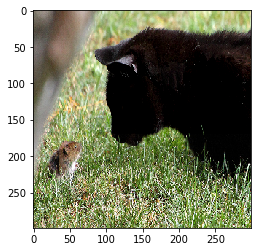

In [85]:
# Testing: Decreasing / increasing influence of superpixel
gamma = 1.00
prediction = 'American_black_bear'
while gamma <= 1.5 and prediction == 'American_black_bear':
    print("\n" + str(gamma))
    index = np.where(mask != 0)
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[index] = alter_image[index] * gamma
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    prediction = tup[1]
    for x in decode_predictions(preds)[0]:
        print(x)
    gamma += .01

alt = alter_image.copy()
alt[np.where(alt > 1)] = 1
alt[np.where(alt < -1)] = -1
plt.imshow(alt / 2 + 0.5)

In [86]:
ex = lime_image.LimeImageExplainer()
expl = ex.explain_instance(alt, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[295, 224, 223, 287, 282]


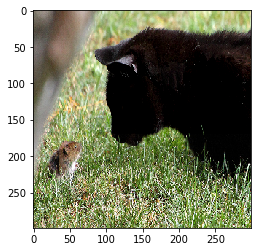

In [88]:
print(expl.top_labels)
plt.imshow(alt / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


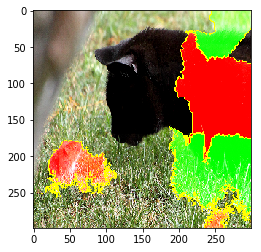

In [89]:
temp, mask = expl.get_image_and_mask(expl.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


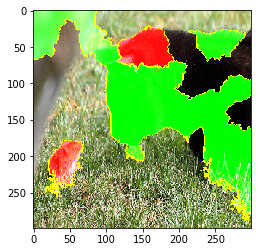

In [104]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [19]:
# # Testing: Decreasing influence of superpixel
# temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)

# gamma = .77
# prediction = 'American_black_bear'
# while gamma <= 1 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask != 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] * gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     print(tup)
#     gamma -= .01

In [20]:
# # Testing: Decreasing influence of all regions other than the superpixel
# gamma = 1.0
# prediction = 'American_black_bear'
# while gamma <= 1 and prediction == 'American_black_bear':
#     print("\n" + str(gamma))
#     index = np.where(mask == 0)
#     alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
#     alter_image[index] = alter_image[index] * gamma
#     preds = inet_model.predict(np.array([alter_image]))
#     tup = decode_predictions(preds)[0][0]
#     prediction = tup[1]
#     print(tup)
#     gamma -= .01

Original Prediction:
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

Testing Vertical Shifts ...

gamma = -1
('n02133161', 'American_black_bear', 0.70613813)
('n01883070', 'wombat', 0.033445094)
('n02105056', 'groenendael', 0.02713227)
('n02104365', 'schipperke', 0.018322205)
('n01877812', 'wallaby', 0.014332624)

gamma = -2
('n02133161', 'American_black_bear', 0.49618313)
('n01883070', 'wombat', 0.048884656)
('n02105056', 'groenendael', 0.047439612)
('n02104365', 'schipperke', 0.042103864)
('n01877812', 'wallaby', 0.02914766)

gamma = -3
('n02133161', 'American_black_bear', 0.6640026)
('n02104365', 'schipperke', 0.048842512)
('n02105056', 'groenendael', 0.041026354)
('n02112137', 'chow', 0.023245703)
('n01877812', 'wallaby', 0.01270685)

gamma = -4
('n02133161', 'American_black_bear', 0.7503277)
('n02104365', 'schipperke', 0.02421

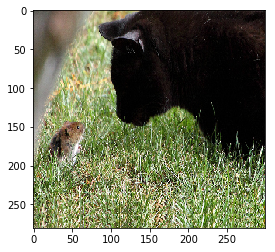

In [21]:
# Testing: Adding small shifts to the image, checking corresponding decisions

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Vertical Shifts ...\n")
# Using negative gammas / pixel shifts (downwards is the positive direction)
for gamma in [x for x in range(-1, -19, -1)]:
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[:gamma] = alter_image[-gamma:]
    alter_image = alter_image[-gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

alt_shift_up = alter_image.copy()
alt_shift_up[np.where(alt_shift_up > 1)] = 1
alt_shift_up[np.where(alt_shift_up < -1)] = -1
plt.imshow(alt_shift_up / 2 + 0.5)

In [22]:
ex_1 = lime_image.LimeImageExplainer()
expl_1 = ex_1.explain_instance(alt_shift_up, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[106, 104, 295, 223, 224]


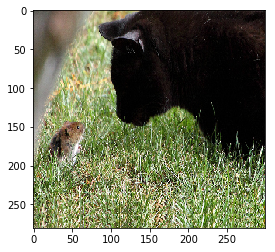

In [23]:
print(expl_1.top_labels)
plt.imshow(alt_shift_up / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


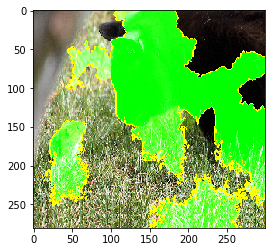

In [46]:
temp, mask = expl_1.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


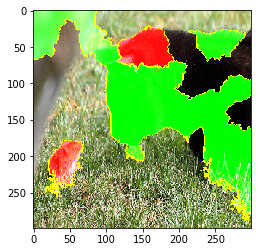

In [130]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [56]:
# Testing: Adding small shifts to the image, checking corresponding decisions

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Vertical Shifts ...\n")
# Positive gammas / pixel shifts downwards (downwards is the positive direction)
gamma = 1
prediction = "American_black_bear"
while prediction == "American_black_bear":
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[gamma:] = alter_image[:-gamma]
    alter_image = alter_image[gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()
    prediction = tup[1]
    gamma += 1

Original Prediction:
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

Testing Vertical Shifts ...

gamma = 1
('n02133161', 'American_black_bear', 0.83528286)
('n01883070', 'wombat', 0.025936583)
('n02105056', 'groenendael', 0.013512902)
('n01877812', 'wallaby', 0.012103776)
('n02104365', 'schipperke', 0.01134735)

gamma = 2
('n02133161', 'American_black_bear', 0.83528286)
('n01883070', 'wombat', 0.025936583)
('n02105056', 'groenendael', 0.013512902)
('n01877812', 'wallaby', 0.012103776)
('n02104365', 'schipperke', 0.01134735)

gamma = 3
('n02133161', 'American_black_bear', 0.83528286)
('n01883070', 'wombat', 0.025936583)
('n02105056', 'groenendael', 0.013512902)
('n01877812', 'wallaby', 0.012103776)
('n02104365', 'schipperke', 0.01134735)

gamma = 4
('n02133161', 'American_black_bear', 0.83528286)
('n01883070', 'wombat', 0.025936583

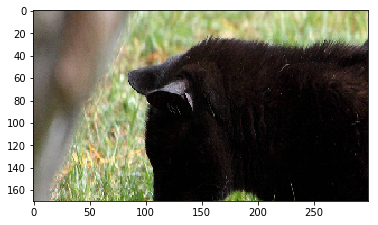

In [57]:
alt_shift_down = alter_image.copy()
alt_shift_down[np.where(alt_shift_down > 1)] = 1
alt_shift_down[np.where(alt_shift_down < -1)] = -1
plt.imshow(alt_shift_down / 2 + 0.5)

In [82]:
ex_6 = lime_image.LimeImageExplainer()
expl_6 = ex_6.explain_instance(alt_shift_down, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[223, 295, 224, 249, 269]


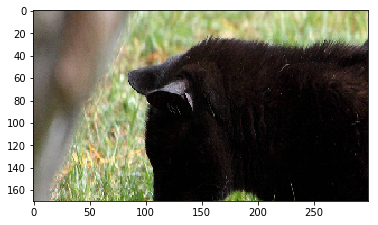

In [83]:
print(expl_6.top_labels)
plt.imshow(alt_shift_down / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


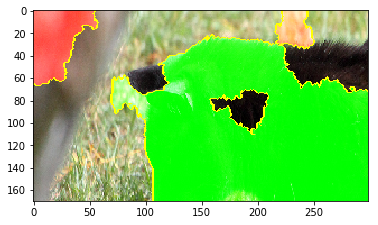

In [84]:
temp, mask = expl_6.get_image_and_mask(expl_6.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


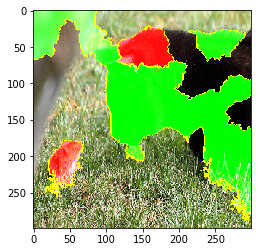

In [130]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [75]:
# Testing: Adding small shifts to the image, checking corresponding decisions
gamma = -4 # Corresponds to size of pixel shift

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Horizontal Shifts ...\n")
# With negative gammas
gamma = -1
prediction = "American_black_bear"
while prediction == "American_black_bear":
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[:, :gamma] = alter_image[:, -gamma:]
    alter_image = alter_image[:, -gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    prediction = tup[1]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()
    gamma -= 1

Original Prediction:
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

Testing Horizontal Shifts ...

gamma = -1
('n02133161', 'American_black_bear', 0.64832336)
('n02105056', 'groenendael', 0.04616095)
('n01877812', 'wallaby', 0.033595525)
('n02104365', 'schipperke', 0.02045557)
('n02119789', 'kit_fox', 0.013900949)

gamma = -2
('n02133161', 'American_black_bear', 0.43699616)
('n02105056', 'groenendael', 0.077911906)
('n02119789', 'kit_fox', 0.05042669)
('n01877812', 'wallaby', 0.035699323)
('n02104365', 'schipperke', 0.035178468)

gamma = -3
('n02133161', 'American_black_bear', 0.25571716)
('n02105056', 'groenendael', 0.057795025)
('n01877812', 'wallaby', 0.04533123)
('n02119789', 'kit_fox', 0.037156805)
('n02127052', 'lynx', 0.030683205)

gamma = -4
('n02133161', 'American_black_bear', 0.4147842)
('n02105056', 'groenendael', 0.078

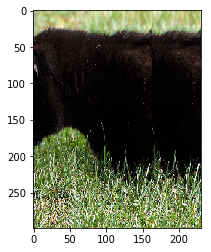

In [76]:
alt_shift_up = alter_image.copy()
alt_shift_up[np.where(alt_shift_up > 1)] = 1
alt_shift_up[np.where(alt_shift_up < -1)] = -1
plt.imshow(alt_shift_up / 2 + 0.5)

In [77]:
ex_7 = lime_image.LimeImageExplainer()
expl_7 = ex_7.explain_instance(alt_shift_up, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[224, 295, 223, 256, 260]


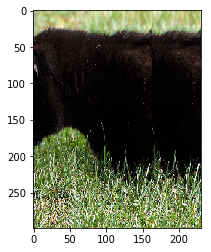

In [78]:
print(expl_7.top_labels)
plt.imshow(alt_shift_up / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


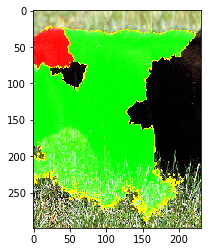

In [79]:
temp, mask = expl_7.get_image_and_mask(expl_7.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


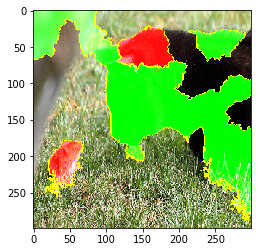

In [130]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [51]:
# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Horizontal Shifts ...\n")
# With positive gammas
gamma = 1
result = "American_black_bear"
while result == "American_black_bear":
    print("gamma = " + str(gamma))
    alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
    alter_image[:, gamma:] = alter_image[:, :-gamma]
    alter_image = alter_image[:, gamma:]
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    result = tup[1]
    gamma += 1
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

Original Prediction:
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

Testing Horizontal Shifts ...

gamma = 1
('n02133161', 'American_black_bear', 0.53078383)
('n02105056', 'groenendael', 0.102131195)
('n01877812', 'wallaby', 0.04446053)
('n02104365', 'schipperke', 0.042117976)
('n02119789', 'kit_fox', 0.015399357)

gamma = 2
('n02133161', 'American_black_bear', 0.53078383)
('n02105056', 'groenendael', 0.102131195)
('n01877812', 'wallaby', 0.04446053)
('n02104365', 'schipperke', 0.042117976)
('n02119789', 'kit_fox', 0.015399357)

gamma = 3
('n02133161', 'American_black_bear', 0.53078383)
('n02105056', 'groenendael', 0.102131195)
('n01877812', 'wallaby', 0.04446053)
('n02104365', 'schipperke', 0.042117976)
('n02119789', 'kit_fox', 0.015399357)

gamma = 4
('n02133161', 'American_black_bear', 0.53078383)
('n02105056', 'groenendael', 0

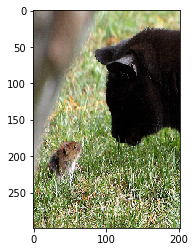

In [52]:
alt_shift_left = alter_image.copy()
alt_shift_left[np.where(alt_shift_left > 1)] = 1
alt_shift_left[np.where(alt_shift_left < -1)] = -1
plt.imshow(alt_shift_left / 2 + 0.5)

In [53]:
ex_2 = lime_image.LimeImageExplainer()
expl_2 = ex_2.explain_instance(alt_shift_left, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[278, 224, 223, 295, 287]


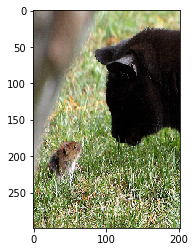

In [54]:
print(expl_2.top_labels)
plt.imshow(alt_shift_left / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


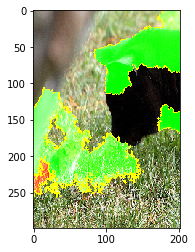

In [55]:
temp, mask = expl_2.get_image_and_mask(expl_2.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


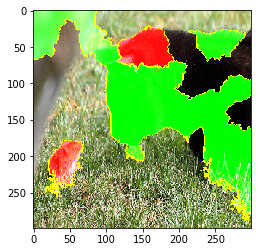

In [130]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [32]:
# Testing: Rotations

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing 90 Degree Rotations ...\n")
for i in range(1, 3):
    print("Rotated: " + str(i * 90) + " degrees counterclockwise")
    alter_image = np.rot90(alter_image)
    preds = inet_model.predict(np.array([alter_image]))
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

Original Prediction:
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

Testing 90 Degree Rotations ...

Rotated: 90 degrees counterclockwise
('n02133161', 'American_black_bear', 0.13191111)
('n02480855', 'gorilla', 0.07502122)
('n02492660', 'howler_monkey', 0.06381178)
('n02410509', 'bison', 0.057392053)
('n02437616', 'llama', 0.056557532)

Rotated: 180 degrees counterclockwise
('n01872401', 'echidna', 0.2285629)
('n01883070', 'wombat', 0.13900916)
('n01514859', 'hen', 0.08975385)
('n02442845', 'mink', 0.07283358)
('n02346627', 'porcupine', 0.054075405)



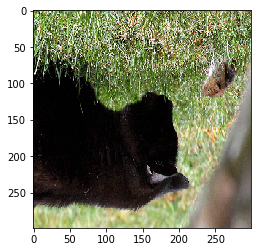

In [33]:
alt_rot_180 = alter_image.copy()
alt_rot_180[np.where(alt_rot_180 > 1)] = 1
alt_rot_180[np.where(alt_rot_180 < -1)] = -1
plt.imshow(alt_rot_180 / 2 + 0.5)

In [34]:
ex_3 = lime_image.LimeImageExplainer()
expl_3 = ex_3.explain_instance(alt_rot_180, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[102, 106, 8, 357, 334]


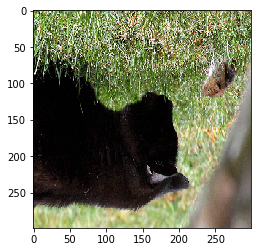

In [35]:
print(expl_3.top_labels)
plt.imshow(alt_rot_180 / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


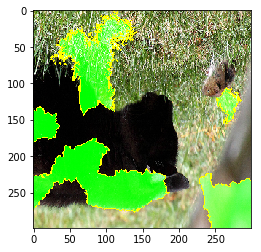

In [48]:
temp, mask = expl_3.get_image_and_mask(102, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


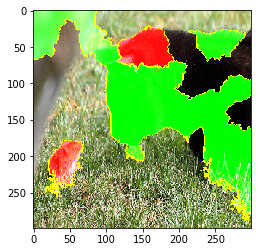

In [130]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [37]:
# Testing: Rotations

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing 90 Degree Rotations ...\n")
for i in range(1, 4):
    print("Rotated: " + str(i * 90) + " degrees counterclockwise")
    alter_image = np.rot90(alter_image)
    preds = inet_model.predict(np.array([alter_image]))
    preds = inet_model.predict(np.array([alter_image]))
    tup = decode_predictions(preds)[0][0]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()

Original Prediction:
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

Testing 90 Degree Rotations ...

Rotated: 90 degrees counterclockwise
('n02133161', 'American_black_bear', 0.13191111)
('n02480855', 'gorilla', 0.07502122)
('n02492660', 'howler_monkey', 0.06381178)
('n02410509', 'bison', 0.057392053)
('n02437616', 'llama', 0.056557532)

Rotated: 180 degrees counterclockwise
('n01872401', 'echidna', 0.2285629)
('n01883070', 'wombat', 0.13900916)
('n01514859', 'hen', 0.08975385)
('n02442845', 'mink', 0.07283358)
('n02346627', 'porcupine', 0.054075405)

Rotated: 270 degrees counterclockwise
('n02104365', 'schipperke', 0.8006328)
('n02133161', 'American_black_bear', 0.054653108)
('n02105056', 'groenendael', 0.04369681)
('n02480855', 'gorilla', 0.0032963404)
('n02442845', 'mink', 0.002414502)



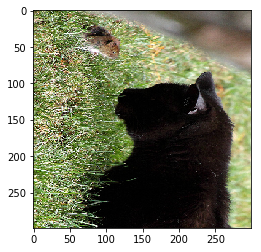

In [38]:
alt_rot_270 = alter_image.copy()
alt_rot_270[np.where(alt_rot_270 > 1)] = 1
alt_rot_270[np.where(alt_rot_270 < -1)] = -1
plt.imshow(alt_rot_270 / 2 + 0.5)

In [39]:
ex_4 = lime_image.LimeImageExplainer()
expl_4 = ex_4.explain_instance(alt_rot_270, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[223, 295, 224, 366, 357]


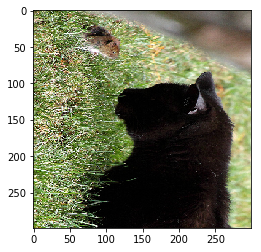

In [40]:
print(expl_4.top_labels)
plt.imshow(alt_rot_270 / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


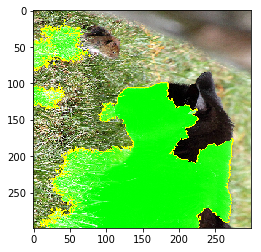

In [49]:
temp, mask = expl_4.get_image_and_mask(223, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


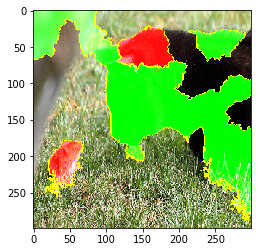

In [130]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

In [41]:
# Testing: Zoom

# Original prediction
alter_image = transform_img_fn([os.path.join('data','cat_mouse.jpg')])[0]
preds = inet_model.predict(np.array([alter_image]))
print("Original Prediction:")
for x in decode_predictions(preds)[0]:
    print(x)
print()

print("Testing Zoom In ...\n")
# zoom should be < (299/2)
zoom, result = 1, "American_black_bear"
while zoom < 299 / 2 and result == "American_black_bear":
    print("zoom = " + str(zoom))
    zoomed = alter_image[zoom:-zoom, zoom:-zoom]
    preds = inet_model.predict(np.array([zoomed]))
    preds = inet_model.predict(np.array([zoomed]))
    tup = decode_predictions(preds)[0][0]
    result = tup[1]
    for x in decode_predictions(preds)[0]:
        print(x)
    print()
    zoom += 1

Original Prediction:
('n02133161', 'American_black_bear', 0.6371607)
('n02105056', 'groenendael', 0.03181797)
('n02104365', 'schipperke', 0.029944355)
('n01883070', 'wombat', 0.02850929)
('n01877812', 'wallaby', 0.025093487)

Testing Zoom In ...

zoom = 1
('n02133161', 'American_black_bear', 0.8004807)
('n02105056', 'groenendael', 0.03531607)
('n02119789', 'kit_fox', 0.019865477)
('n01877812', 'wallaby', 0.01636766)
('n02104365', 'schipperke', 0.013046979)

zoom = 2
('n02133161', 'American_black_bear', 0.58600557)
('n01877812', 'wallaby', 0.075182624)
('n02105056', 'groenendael', 0.03823232)
('n02119789', 'kit_fox', 0.027865553)
('n02442845', 'mink', 0.027750352)

zoom = 3
('n02133161', 'American_black_bear', 0.6306107)
('n02119789', 'kit_fox', 0.062596016)
('n02105056', 'groenendael', 0.049407333)
('n01877812', 'wallaby', 0.028843967)
('n02442845', 'mink', 0.019423602)

zoom = 4
('n02133161', 'American_black_bear', 0.4212876)
('n02105056', 'groenendael', 0.11086331)
('n01877812', 'wal

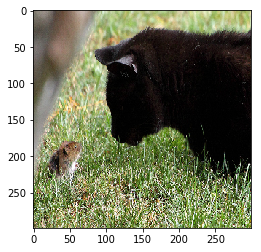

In [42]:
alt_zoom = alter_image.copy()
alt_zoom[np.where(alt_zoom > 1)] = 1
alt_zoom[np.where(alt_zoom < -1)] = -1
plt.imshow(alt_zoom / 2 + 0.5)

In [43]:
ex_5 = lime_image.LimeImageExplainer()
expl_5 = ex_5.explain_instance(alt_zoom, inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

[295, 224, 223, 106, 104]


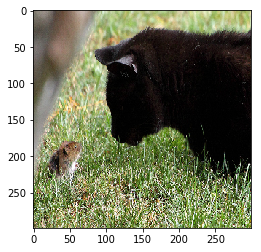

In [44]:
print(expl_5.top_labels)
plt.imshow(alt_zoom / 2 + 0.5)
# prev top labels:
# [295, 224, 223, 106, 104]

Contributing features in perturbed:


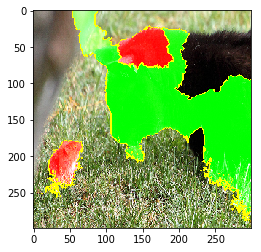

In [50]:
temp, mask = expl_5.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in perturbed:")

Contributing features in original:


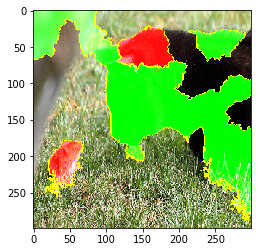

In [130]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print("Contributing features in original:")

### Let's see the explanation for Wombat

Most positive towards wombat:

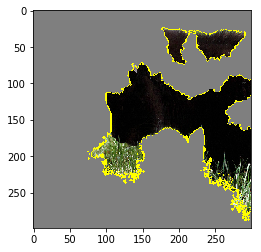

In [33]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

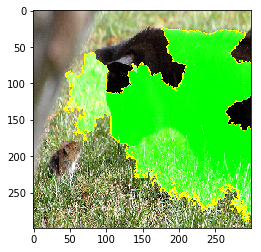

In [16]:
temp, mask = explanation.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
